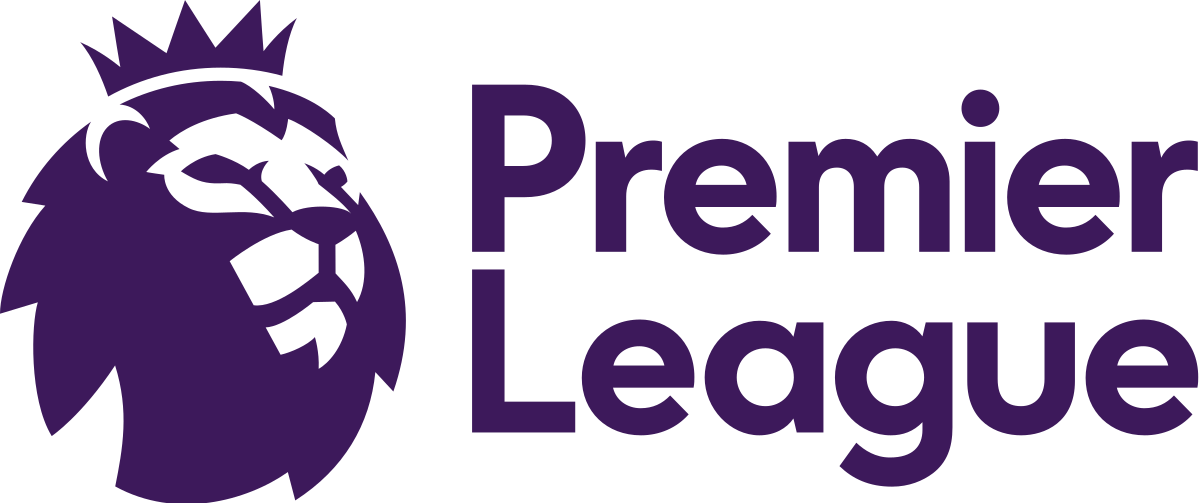

# In this notebook, We will have analysis and visualizations for the last 3 completed seasons in PL

## This Notebook will be divided into two parts: Web Scraping and Data Analysis

##### Importing libraries that is needed for this project

In [1]:
import os 
import pandas as pd
import numpy as np
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

## Scraping Team Links for Each Season

##### In the next cell we will get link for each team in every season listed in "seasons" list to have detailed stats for each team later and result will be stored in "teams_link" list 

In [2]:
#Intiate Chrome Driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

#Seasons to scrape
seasons=["2021-2022","2020-2021","2019-2020"]
#Intiate empty list of lists to store the resultant links in it
teams_link=[[] for i in range(len(seasons))]


# Main page of Premier League Stats
driver.get("https://fbref.com/en/comps/9/Premier-League-Stats")

#Scrape for each season
for season in range(len(seasons)):
    
    # We hit previous button to reach previous season
    previous=driver.find_element(By.XPATH,"/html/body/div[2]/div[4]/div[1]/div[2]/div/a")
    previous.click()
    
    #Find the table of standings by table then choosing cells on the left to obtain links
    standings=driver.find_element(By.ID,"results"+seasons[season]+"91_overall")\
                   .find_elements(By.CLASS_NAME,"left")
    
    #Obtain a tags for each row including teams and last matches
    a_tags=[]
    for i in range(len(standings)):
        a_tag=standings[i].find_elements(By.TAG_NAME,"a")
        a_tags.append(a_tag)
        
    # Obtain the links('href') for each team and exclude the last matches link
    for i in range(len(a_tags)):
        for j in range(len(a_tags[i])):
            team_link=a_tags[i][j].get_attribute("href")
            # Obtain team links only not last matches links
            if (team_link.find("https://fbref.com/en/squads") != -1):
                teams_link[season].append(team_link)   
#Quit session
driver.quit()

## Create Data Structure To Obtain The Data To Be Scraped for Teams

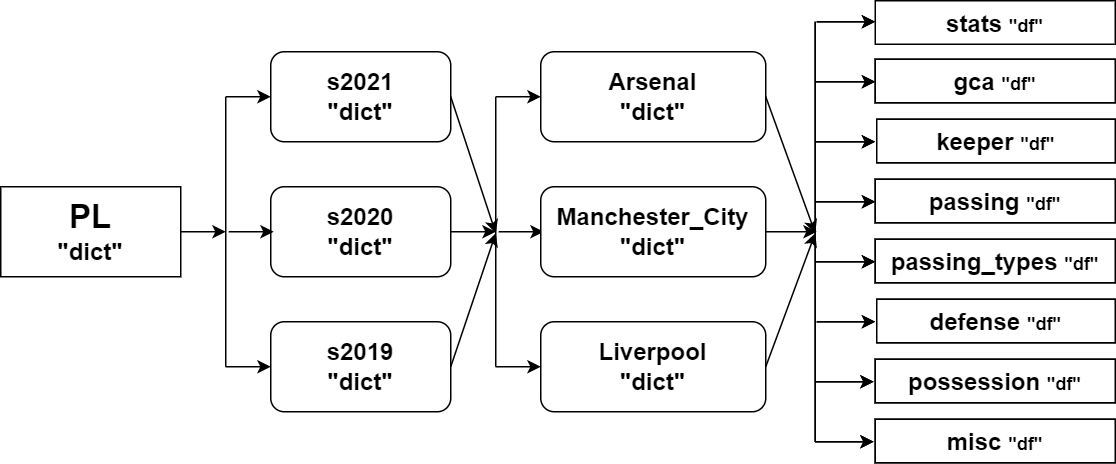

In [3]:
PL={}
teams={}
stats=["stats","shooting","keepers","passing","passing_types","gca","defense","possession","misc"]


# We want to get teams name participing in the competition every year 
# Every link in teams_link has "-Stats" in the end so we want to get rid from it and Let's take example
# "https://fbref.com/en/squads/b8fd03ef/2021-2022'/'Manchester-City-Stats"
# As you can see it and i put a / in single quotes to mark it. That's our start
# As this / , its place is constant in every link that explains the No. 47 written down in the slicing

for season in range(len(seasons)):
    for team in range(20):
        team_struc={}
        for stat in stats:
                #Create Structre for every team where each team has dataframe for every type of stats for the matches
                team_struc[stat]=pd.DataFrame(index=range(1,39))
        #Assign type of stats for each team
        teams[teams_link[season][team][47:-6].replace("-","_")]=team_struc
    PL['s' + seasons[season][:4]] = teams

## Scraping every match Stats for every team in every season

##### In the next cell we will get match stats for each team in every season listed in

In [4]:
#Intiate Chrome Driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

#Loop for every season
for season in range(len(seasons)):
    
    #Loop for every team
    for team in range(20):
        
        # Main page of Team Stats
        driver.get(teams_link[season][team])
        
        #Convert matches to PL instead of All Competitions
        pl_matches=driver.find_element(By.XPATH,"/html/body/div[2]/div[7]/div[5]/div[2]")
        pl_matches=pl_matches.find_element(By.TAG_NAME,"a").get_attribute("href")
        driver.get(pl_matches)
        
        #Finds the table of stats
        matches=driver.find_element(By.ID,"matchlogs_for")

        #Get HTML of the table and read it into pandas df
        team_info=pd.read_html(matches.get_attribute("outerHTML"))
        PL["s"+seasons[season][:4]][teams_link[season][team][47:-6].replace("-","_")]["stats"]=team_info[0]
        
        #Make as info for rest of stats
        for stat in range(1,len(stats)):
            
            #Convert matches to Desired Stat instead of Scores & Fixtures
            stat_matches=driver.find_element(By.XPATH,"/html/body/div[2]/div[7]/div[3]/div["+str((stat+1))+"]/a")\
            .get_attribute("href")
            driver.get(stat_matches)
            
        
            #Scrap stats about matches for each team
            #Finds the table of stats
            matches=driver.find_element(By.ID,"matchlogs_for")
            #Get HTML of the table and read it into pandas df
            team_stat=pd.read_html(matches.get_attribute("outerHTML"))
            #Assign the table to the desired df
            PL["s"+seasons[season][:4]][teams_link[season][team][47:-6].replace("-","_")][stats[(stat)]]=team_stat[0]

        
        
#Quit session
driver.quit()        

## Scraping every player Stats in every season

##### In the next cell we will get player stats in every season listed in

In [16]:
stats=["stats","keepers","keepersadv","passing","passing_types","gca","defense","possession","playingtime","misc"]
#Intiate Chrome Driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

for season in seasons:        
    for stat in stats:
        
        stat_pg=driver.get("https://fbref.com/en/comps/9/"+str(season)+"/"+str(stat)+"/"+str(season)+"-Premier-League-Stats")
        #Scrap table about players stats
        players_stat=driver.find_element(By.XPATH,"/html/body/div[2]/div[7]/div[3]/div[4]")
        players_stat=pd.read_html((players_stat.get_attribute("innerHTML")))
        #Create stat df to hold players for every stat
        PL["s"+season[:4]][stat]=players_stat[0]

#Quit session
driver.quit()                

## Save Scraped Data into files to have accsess on them  later

In [17]:
os.mkdir("PL")
for season in range(len(seasons)):
    os.mkdir("PL"+"/"+seasons[season][:4])
    stats=["stats","keepers","keepersadv","passing","passing_types","gca","defense","possession","playingtime","misc"]
    for stat in stats:
        PL["s"+seasons[season][:4]][stat].to_csv("PL"+"/"+seasons[season][:4]+"/"+stat+".csv")
    for team in range(20):
        stats=["stats","shooting","keepers","passing","passing_types","gca","defense","possession","misc"]
        os.mkdir("PL"+"/"+seasons[season][:4]+"/"+teams_link[season][team][47:-6].replace("-","_"))
        for stat in stats:
            PL["s"+seasons[season][:4]][teams_link[season][team][47:-6].replace("-","_")][stat].to_csv("PL"+"/"+seasons[season][:4]+"/"+teams_link[season][team][47:-6].replace("-","_")+"/"+stat+".csv")